# Regresión con redes neuronales

In [1]:
pip install -q seaborn

In [54]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


En este problema de regresión vamos a predecir la eficiencia de los vehiculos de 1970 y 1980. Para ellos intentaremos predecir la variable MPG(Millas por galón) de nuestro dataset

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 1us/step


'/root/.keras/datasets/auto-mpg.data'

In [21]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
raw_data_set = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)

data_set = raw_data_set.copy()
data_set.head()
data_set.shape

(398, 8)

In [17]:
#Comprobamos que valores son nulos
#data_set.info()
#data_set.shape
data_set.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [22]:
data_set = data_set.dropna()
data_set.isna().sum()
data_set.shape

(392, 8)

In [23]:
data_set.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


Comprobamos que la variable "Origin" es realmente categorica. Asi que la transformamos en una variable "one-hot"

In [25]:
origin = data_set.pop('Origin')

In [26]:
data_set['USA'] = (origin == 1)*1.0
data_set['EU'] = (origin == 2)*1.0
data_set['Japan'] = (origin == 3)*1.0
data_set.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,EU,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0


Dividimos los datos en entrenamiento y prueba

In [28]:
#Cogemos el 80% de los datos para el entrenamiento
train_dataset = data_set.sample(frac=0.8, random_state=0)
#Utilozamos drop para sacar el 20% restante
test_dataset = data_set.drop(train_dataset.index)

Ahora vamos a visualizar los datos de entrenamiento

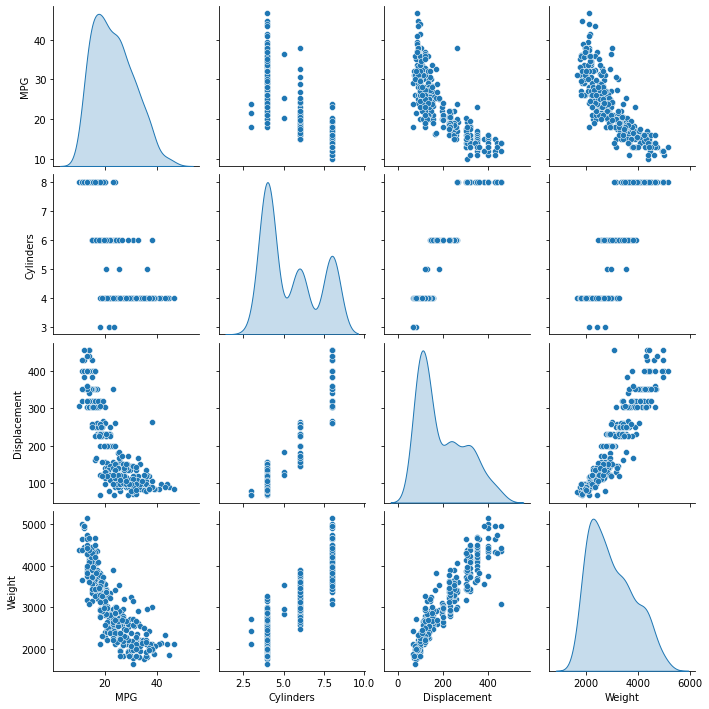

In [29]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Revisamos la distribución de los datos

In [51]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
EU,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [34]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

Normalizamos los datos para favorecer el entrenamiento de nuestro modelo.

In [35]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Ahora pasamos a crear el modelo. La arquitectura de nuestra red estará compuesta por dos capas ocultas densamente conectadas y una capa de salida con un único valor continuo. 

In [40]:
def build_model():
  model = keras.Sequential([
                            layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mse'])
  return model

In [41]:
model = build_model()

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [43]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.57869583],
       [0.39609405],
       [0.7800047 ],
       [0.743122  ],
       [0.2021975 ],
       [0.25010696],
       [0.20215684],
       [0.1546968 ],
       [0.17964144],
       [0.32769275]], dtype=float32)

Comprobamos que unos datos de prueba que la slida es la esperada. Ahora pasamos a entrenar el modelo

In [44]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [46]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.676191,1.013716,2.676191,9.680829,2.309995,9.680829,995
996,2.628907,0.996869,2.628907,9.012794,2.212742,9.012794,996
997,2.663167,0.979536,2.663167,9.073354,2.230725,9.073354,997
998,2.636671,0.997714,2.636671,9.100735,2.230710,9.100735,998
999,2.658961,1.000219,2.658961,9.503897,2.288079,9.503897,999


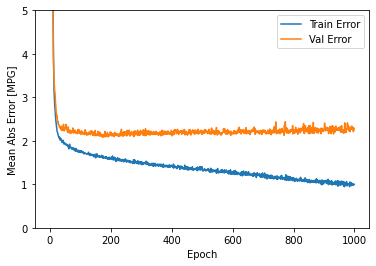

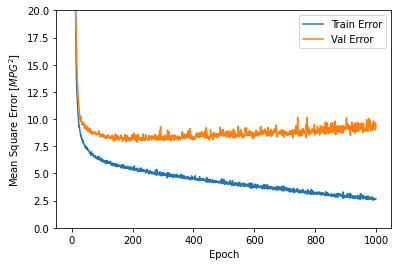

In [47]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

En la gráfica observamos poca mejora, despues de las 100 iteraciones. Por ello dentendremos el entrenamiento cuando esto pase, con "EarlyStopping"


................................................................................................

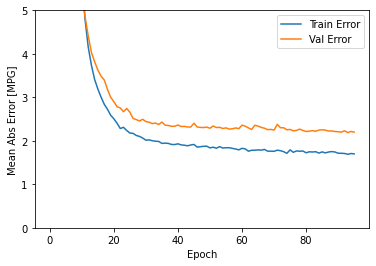

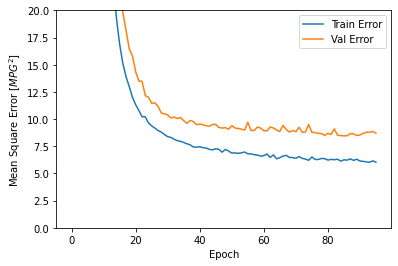

In [48]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

Con este nuevo parametro vemos como el eeror promedio de +-2. Teniendo en cuenta que la media esta en torno a 23, no son malos resultados.

In [49]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.0216 - mae: 1.9554 - mse: 6.0216
Testing set Mean Abs Error:  1.96 MPG


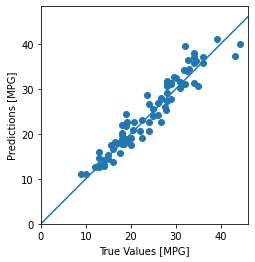

In [50]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

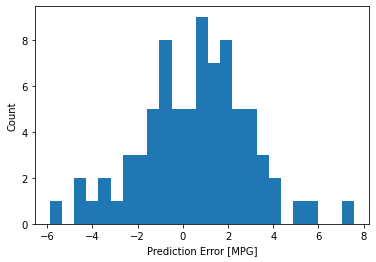

In [53]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")